In [50]:
import copy
import glob
import os
import pprint
import traceback
import time
from collections import deque
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import re
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
sys.path.insert(0, '..')

import gym
import gym_nav
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate



# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data



def print_runs(folder='../runs/'):
    '''
    print tensorboard runs directories
    
    prints out each unique experiment name and how many trials were associated
    next use load_exp_df with the name and trial number to load it into a df
    '''
    space =  '    '
    branch = '│   '
    tee =    '├── '
    last =   '└── '
    
    path = Path(folder)
    print(path.name)
    
    unique_experiments = {}
    original_experiment_names = {}
    depth = 0
    for d in path.iterdir():
        if '__' in d.name:
            trial_name = d.name.split('__')[0]
            
            if re.match('.*\_\d*', trial_name):
                exp_name = '_'.join(trial_name.split('_')[:-1])
            else:
                exp_name = trial_name
                
            if exp_name in unique_experiments.keys():
                unique_experiments[exp_name] += 1
            else:
                unique_experiments[exp_name] = 1
                
    for key, value in unique_experiments.items():
        if value > 1:
            print(branch*depth + tee+'EXP', key + ':', value)
        else:
            print(branch*depth+tee+key)

    return unique_experiments



def load_exp_df(exp_name, trial_num=0, folder='../runs/', save_csv=True):
    '''
    load experiment tensorboard run into a dataframe
    if save_csv is True, also convert into a csv for faster loading later
    '''
    dirs = os.listdir(folder)
    results = []
    for d in dirs:
        if '__' in d:
            trial_name = d.split('__')[0]
            if re.match('.*\_\d*', trial_name):
                name = '_'.join(trial_name.split('_')[:-1])
                trial = int(trial_name.split('_')[-1])
                
                if exp_name == name and trial == trial_num:
                    results.append(folder + d)
                    
    if len(results) > 1:
        print('Warning: more than one experiment with the name and trial num found')
    if len(results) == 0:
        print('No experiments found')
        return None
    
    path = results[0]
    files = os.listdir(path)
    
    #look for a preconverted csv dataframe file
    for file in files:
        if '.csv' in file:
            df = pd.read_csv(path + '/' + file)
            return df
    
    #no preconverted csv found, convert the events file
    for file in files:
        if 'events.out.tfevents' in file:
            df = tflog2pandas(path + '/' + file)
            
            if save_csv:
                df.to_csv(path + '/' + 'tflog.csv')
            
            return df
        
    print('No tf events file correctly found')
    return results



def plot_exp_df(df, smoothing=0.1):
    '''
    Plot the experiments values from tensorboard df
    (get the df from load_exp_df)
    '''
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))

    for i, chart in enumerate(df['metric'].unique()):
        # print(chart)
        x = i // 3
        y = i % 3
        idx = df['metric'] == chart
        df.loc[idx, 'ewm'] = df.loc[idx, 'value'].ewm(alpha=smoothing).mean()
        d = df[df['metric'] == chart]

        ax[x, y].plot(d['step'], d['value'], c='C0', alpha=0.1)
        ax[x, y].plot(d['step'], d['ewm'], c='C0')
        ax[x, y].set_title(chart)


In [22]:
exps = print_runs()

runs
├── EXP nav_visible_dist: 5
├── EXP nav_visible_none: 5


{'nav_visible_dist': 5, 'nav_visible_none': 5}

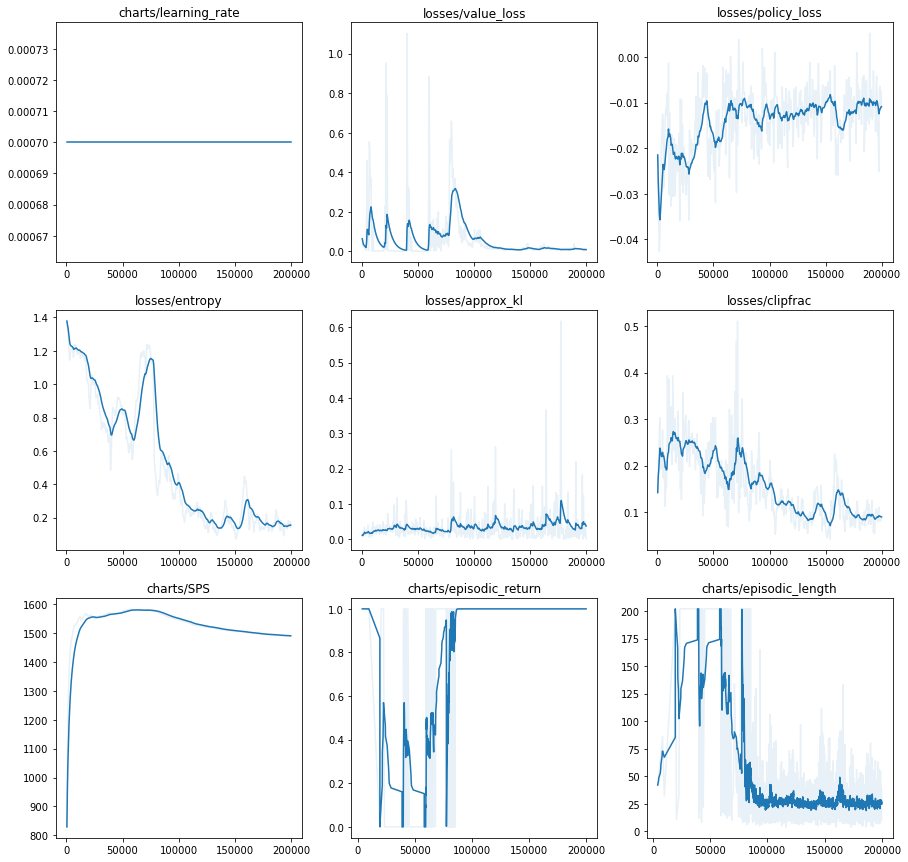

In [51]:
df = load_exp_df('nav_visible_none')
plot_exp_df(df)